In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py
import pandas as pd
%matplotlib inline
import random
from tqdm import tqdm
os.chdir('/hgst8TB/fjurisic/ecoli')

ll = list(map(lambda x:x[:-6], os.listdir('./pass')))

fname = ll[0]

In [45]:
fname

'40525_ch500_read242_strand'

In [5]:
gg = []
for name in ll[:1]:
    h5 = h5py.File(os.path.join('pass', name +'.fast5'), 'r', driver='core')
    
    reads = h5['Analyses/EventDetection_000/Reads']
    assert len(reads.keys()) == 1

    read_str = list(reads.keys())[0]
    events = pd.DataFrame(np.array(reads[read_str + '/Events']))
    
    dur = h5['Raw/Reads/' + read_str].attrs['duration']
    signal = h5['Raw/Reads/' + read_str]['Signal']
    
    sol_len = events['length'].sum()
    #gg.append((dur, sol_len, sol_len/dur, sol_len_2/dur, name))

#gg = pd.DataFrame(gg)
name, events['length'].sum(), signal
    
# gg

('40525_ch500_read242_strand',
 98556,
 <HDF5 dataset "Signal": shape (143496,), type "<i2">)

In [43]:
start_pad = events.iloc[0].start - h5['Raw/Reads/Read_242'].attrs['start_time']
print(start_pad)
print(start_pad + events['length'].sum())
signal.shape[0]

44940.0
143496.0


143496

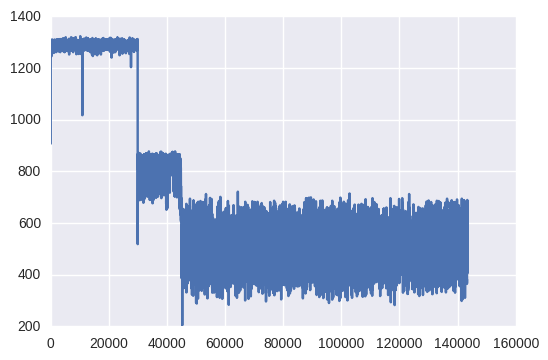

In [127]:
plt.plot(signal)

In [126]:
x, x_len, y, y_len = 

98556


(5000, array([62, 71, 39, 68, 71], dtype=int32))

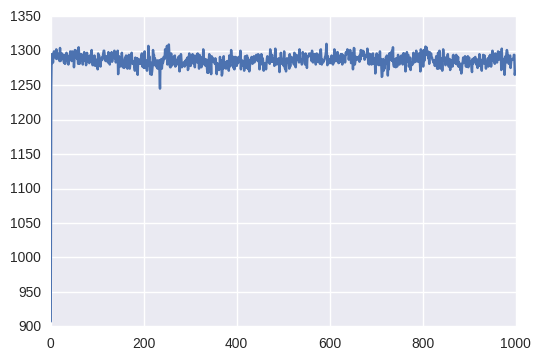

In [17]:
signal = h5['Raw/Reads/Read_242/Signal']
plt.plot(signal[:1000])

In [35]:
h5['Raw/Reads/Read_242'].attrs['duration']

143496

In [36]:
events = np.array(h5['/Analyses/Basecall_1D_000/BaseCalled_template/Events'].value[['mean', 'stdv', 'model_state', 'move', 'start',
            'length']])
pd.DataFrame(events)['length'].sum()

23.811000000000007

In [128]:
def read_fast5(filename, block_size = 50, num_blocks = 1):
    def next_num(prev, symbol):
        val = {
                'A':0,
                'G':1,
                'T':2,
                'C':3,
            }[symbol]
        if symbol == prev:
            return 'N', val+4
        else:
            return symbol, val
    
    'This assumes we are in the right dir.'
    with h5py.File(os.path.join('pass', filename+'.fast5'), 'r') as h5:
        reads = h5['Analyses/EventDetection_000/Reads']
        events = np.array(reads[list(reads.keys())[0] + '/Events'])

        basecalled_events = h5['/Analyses/Basecall_1D_000/BaseCalled_template/Events']
        basecalled = np.array(basecalled_events.value[['mean', 'stdv', 'model_state', 'move', 'start',
            'length']])

        length = block_size * num_blocks
        if events.shape[0] < block_size * num_blocks:
            print("WARNING...less then truncate events", filename)
        
        # x[i] is feat values for event #i
        x = np.zeros([length, 3], dtype=np.float32)
        x_len = np.zeros([num_blocks], dtype=np.int32)
        
        for i in range(num_blocks):
            x_len[i] = max(0, min(block_size, events.shape[0] - i*block_size))
        
        # y[2*i] and y[2*i + 1] are bases for event #i
        y = np.zeros([length], dtype=np.uint8)
        y_len = np.zeros([num_blocks], dtype=np.uint8)
        
        bcall_idx = 0
        prev, curr_sec = "N", 0
        for i, e in enumerate(events[:length]):
            if i // block_size > curr_sec:
                prev, curr_sec = "N", i // block_size

            if bcall_idx < basecalled.shape[0]:
                b = basecalled[bcall_idx]
                if b[0] == e[2] and b[1] == e[3]: # mean == mean and stdv == stdv
                    add_chr = []
                    if bcall_idx == 0:
                        add_chr.extend(list(b[2].decode("ASCII"))) # initial model state
                    bcall_idx += 1
                    if b[3] == 1:
                        add_chr.append(chr(b[2][-1]))
                    if b[3] == 2:
                        add_chr.append(chr(b[2][-2]))
                        add_chr.append(chr(b[2][-1]))
#                     print(add_chr)
                    for c in add_chr:
                        prev, sym = next_num(prev, c)
                        y[curr_sec * block_size + y_len[curr_sec]] = sym 
                        y_len[curr_sec] += 1
                    if y_len[curr_sec] > block_size:
                        print ("Too many events in block!")
                        return None
                    
        x[:events.shape[0],0] = events['length'][:length]
        x[:events.shape[0],1] = events['mean'][:length]
        x[:events.shape[0],2] = events['stdv'][:length]
    return x, x_len, y, y_len
read_fast5('26075_ch178_read15_strand')

(array([[   6.        ,  131.93005371,    1.47198462],
        [  14.        ,  132.96195984,    1.0950588 ],
        [   8.        ,  134.04930115,    1.10035098],
        [  10.        ,  134.83729553,    1.20257688],
        [  10.        ,  130.55703735,    1.84558904],
        [   7.        ,  117.91835022,    0.31542528],
        [   8.        ,  116.38648987,    1.37689531],
        [   7.        ,  120.27211761,    4.55171728],
        [  12.        ,   88.11256409,    1.33218992],
        [   7.        ,   86.37282562,    0.87586766],
        [  16.        ,   85.01205444,    2.42411423],
        [  11.        ,  105.74484253,    5.23270226],
        [   6.        ,   93.42558289,    1.89437616],
        [   6.        ,   91.5451355 ,    1.24686432],
        [   8.        ,  102.05924225,    5.27667046],
        [   8.        ,   96.9327774 ,    0.97989714],
        [   5.        ,   95.7776413 ,    0.87296325],
        [  10.        ,  110.1227951 ,    1.50787461],
        [ 

In [83]:
def gen_train_dataset(
        block_size = 50,
        num_blocks = 100,
        num_examples = 10000):
    os.chdir('/hgst8TB/fjurisic/ecoli')

    files = list(map(lambda x:x[:-6], os.listdir('./pass')))
    random.shuffle(files)
    X, X_len, Y, Y_len = [], [], [], []
    for file in files[:num_examples]:
        x, x_len, y, y_len = read_fast5(file, block_size=block_size, num_blocks=num_blocks)
        X.append(x)
        X_len.append(x_len)
        Y.append(y)
        Y_len.append(y_len)
    np.savez_compressed(os.path.expanduser('~/dataset_big.npz'), X=X, Y=Y, X_len=X_len, Y_len=Y_len)

gen_train_dataset()
gg = np.load(os.path.expanduser('~/dataset_big.npz'))
gg['X'].shape, gg['X_len'].shape, gg['Y'].shape, gg['Y_len'].shape

WARNING...less then truncate events 40525_ch352_read398_strand1
WARNING...less then truncate events 66703_ch503_read623_strand
WARNING...less then truncate events 66703_ch264_read947_strand
WARNING...less then truncate events 26075_ch48_read3478_strand
WARNING...less then truncate events 26075_ch36_read90_strand1
WARNING...less then truncate events 66703_ch444_read317_strand1
WARNING...less then truncate events 58342_ch34_read273_strand
WARNING...less then truncate events 26075_ch433_read627_strand
WARNING...less then truncate events 26075_ch319_read601_strand
WARNING...less then truncate events 58342_ch246_read84_strand
WARNING...less then truncate events 66703_ch206_read92_strand
WARNING...less then truncate events 26075_ch414_read1362_strand
WARNING...less then truncate events 66703_ch289_read339_strand
WARNING...less then truncate events 40525_ch111_read153_strand
WARNING...less then truncate events 95274_ch87_read435_strand
WARNING...less then truncate events 66703_ch365_read252_s

((10000, 5000, 3), (10000, 100), (10000, 5000), (10000, 100))